 libraries import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

`

In [ ]:
import os
import pandas as pd

train_dir = "C:/Test/DL/skin_cancer_2/skin_cancer_images/Train"
test_dir = "C:/Test/DL/skin_cancer_2/skin_cancer_images/Test"

# Create dataframes
dfs = []

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        dfs.append(pd.DataFrame({'image_path': [image_path], 'label': [label]}))

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        dfs.append(pd.DataFrame({'image_path': [image_path], 'label': [label]}))
        
# Combine dataframes into one dataframe
df = pd.concat(dfs, ignore_index=True)

df

In [3]:
# get list of directories in train_dir
labels = os.listdir(train_dir)

# create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes = len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

EDA (Exploratory Data analysis)`

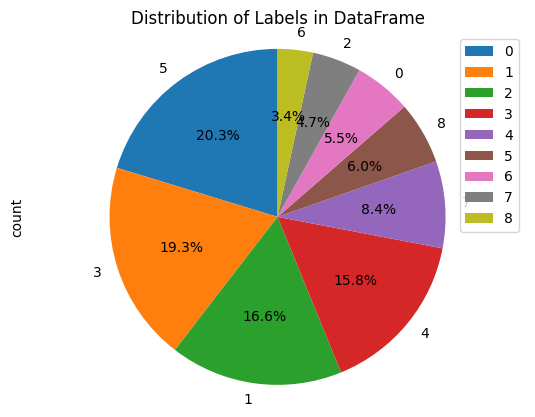

In [4]:
# plot pie chart of the train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [5]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


Loading and resizing the images

In [7]:
max_images_per_class = 2500

# group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\abhin\AppData\Local\Temp\ipykernel_12304\1466211752.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [8]:
import multiprocessing

# get the number of CPU cores
max_workers = multiprocessing.cpu_count()
max_workers

6

In [10]:
import concurrent.futures

# define a function to resize the image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # use executor.amp to apply the function to each image path in the dataframe
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))
    
# add the resized image array to the DataFrame
df['image'] = image_arrays
del image_arrays

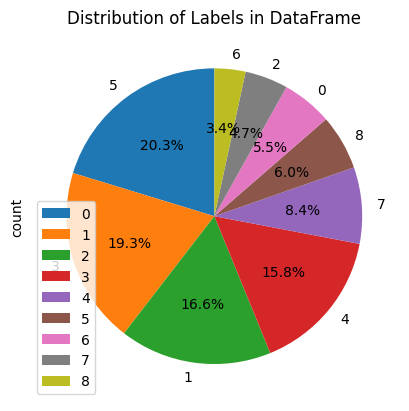

In [12]:
# plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis=('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [ ]:
df.head()

`Displaying the total number of image of each class before augmentation`

In [15]:
# count the number of images in each class
clas_counts = df['label'].value_counts().sort_index()

# print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


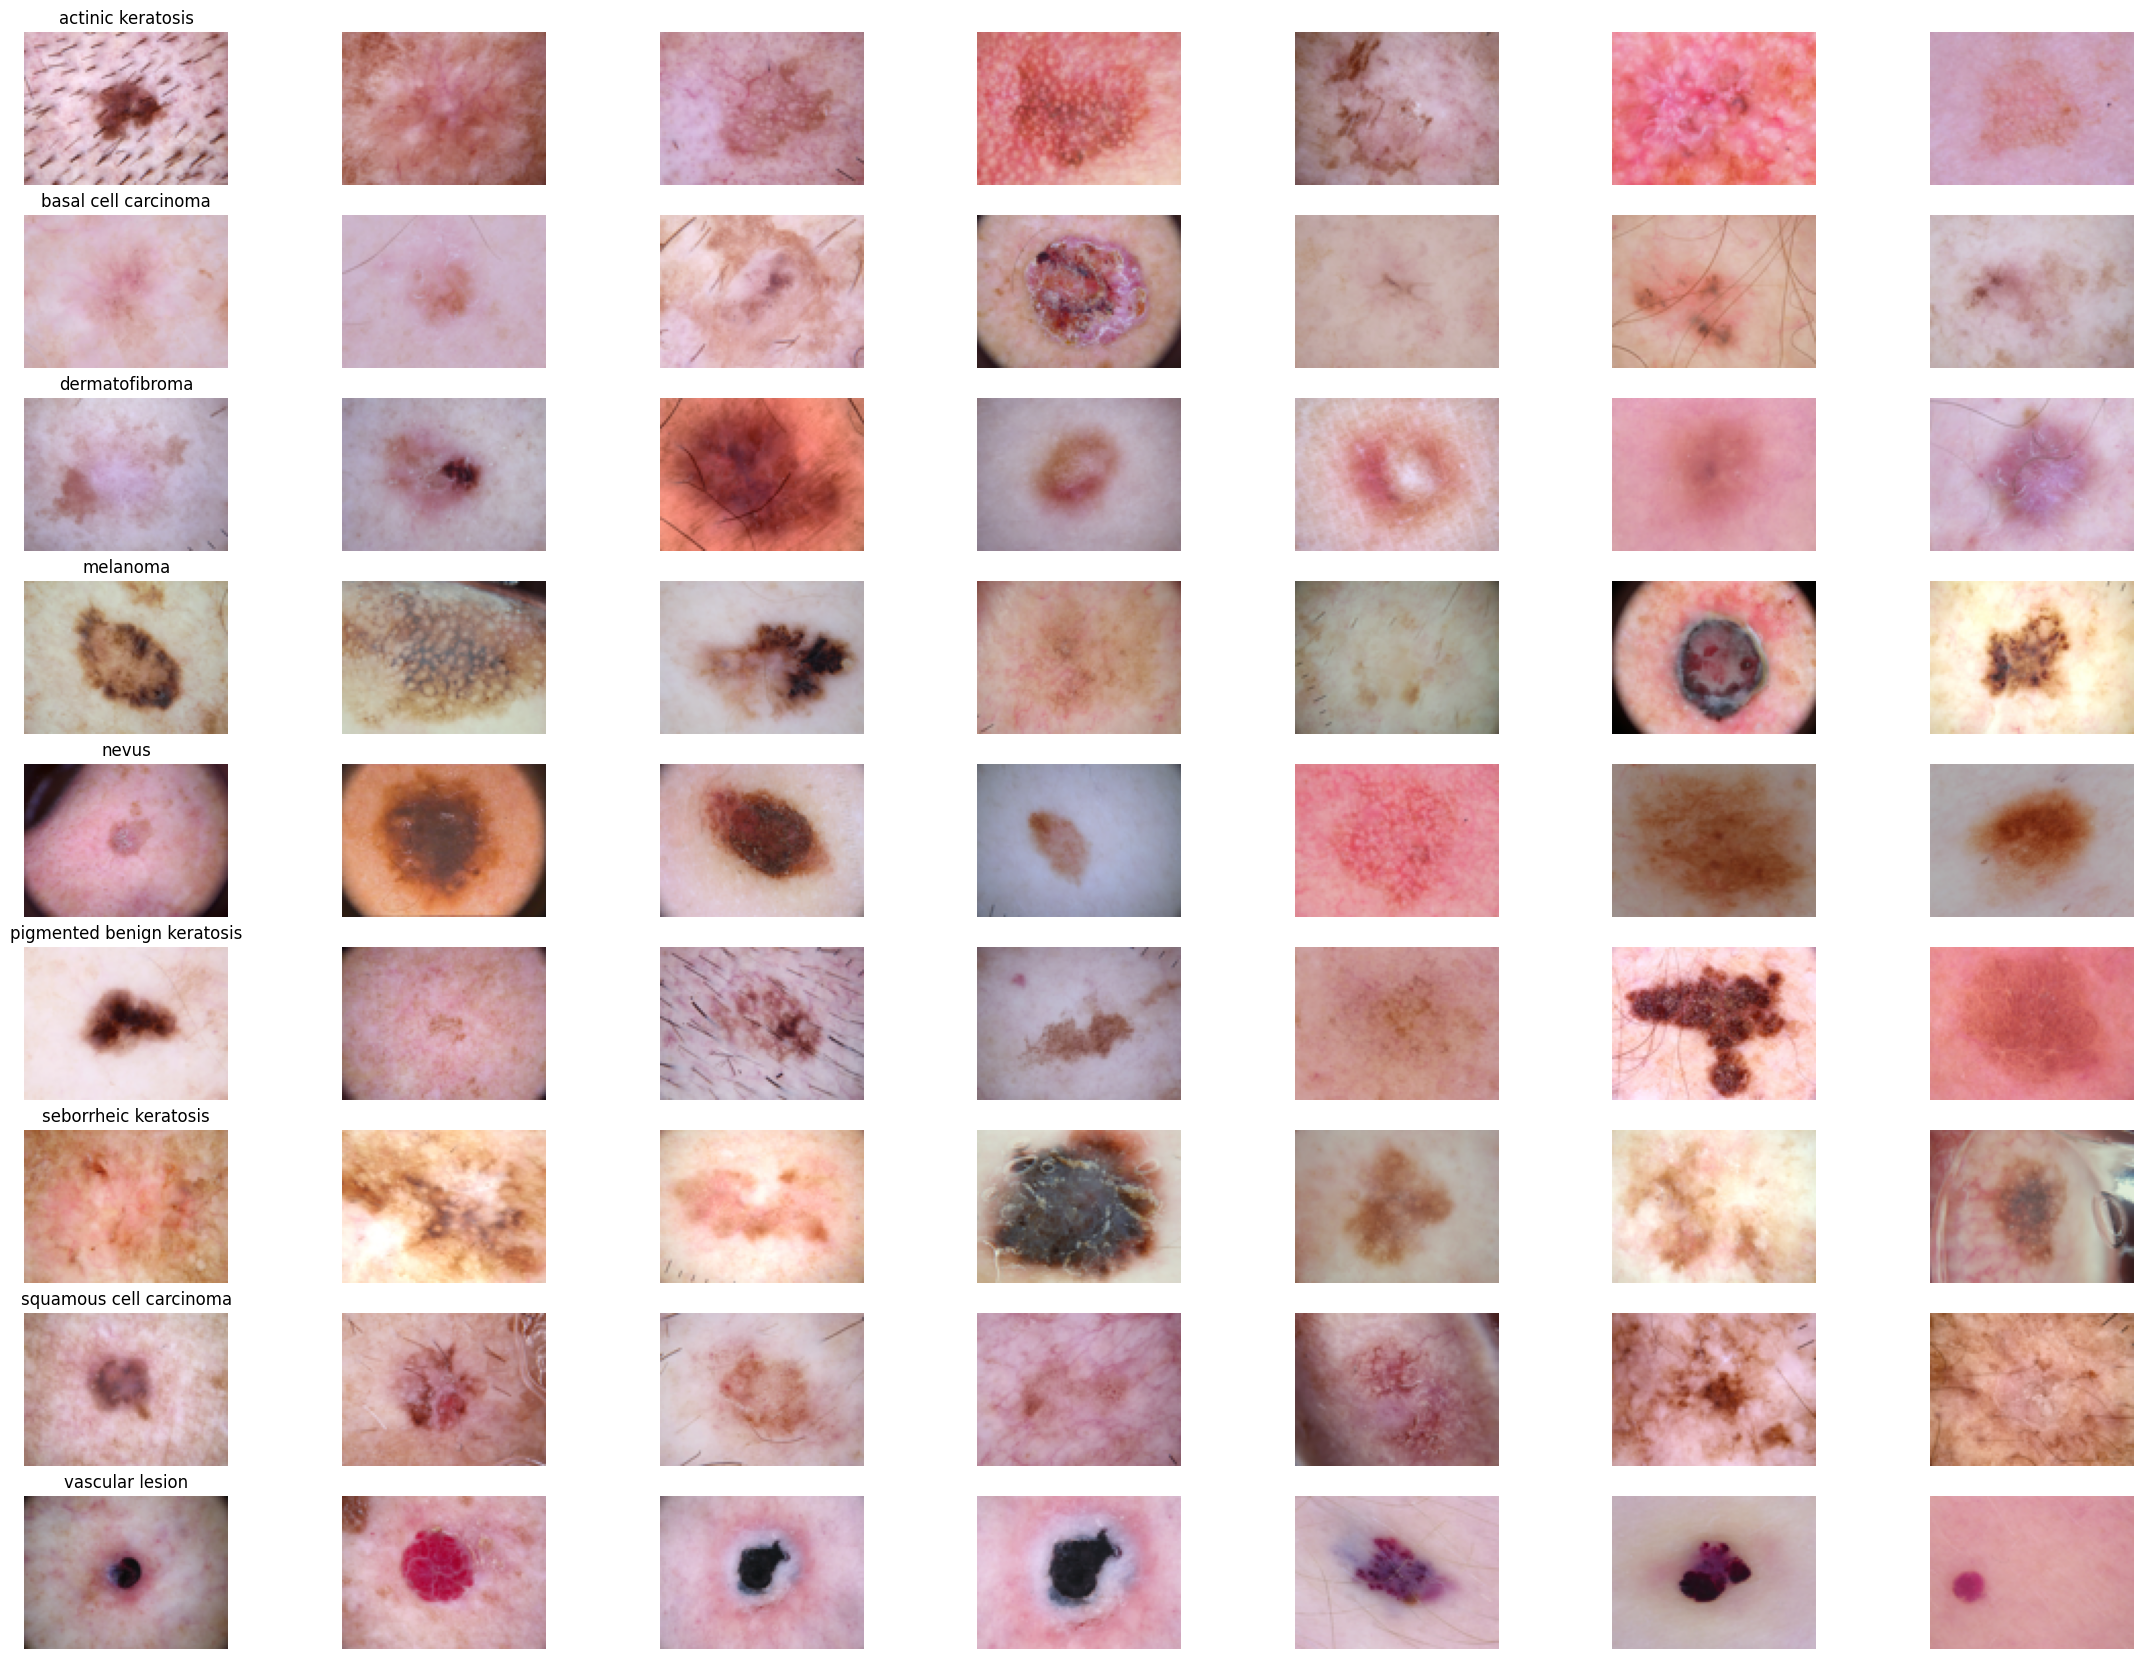

In [17]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=14).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [18]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2357
Name: count, dtype: int64

`Data Augmentation`

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# create an ImageDataGenerator object with the desired transformation
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [24]:
import pandas as pd
import numpy as np

# Initialize an empty list to store augmented data
augmented_data = []

# Assuming datagen is already defined
# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented data list
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented data list
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_data.append({'image_path': None, 'label': class_label, 'image': augmented_image_array})
    
    # Add the original images for the current class to the augmented data list
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_data.extend(original_images_df.to_dict('records'))

# Create DataFrame from augmented data
augmented_df = pd.DataFrame(augmented_data)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

`Displaying the total number of images of each class after data augmentation`

In [26]:
# count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2500      
1               basal cell carcinoma           2500      
2               dermatofibroma                 2500      
3               melanoma                       2500      
4               nevus                          2500      
5               pigmented benign keratosis     2500      
6               seborrheic keratosis           2500      
7               squamous cell carcinoma        2500      
8               vascular lesion                2500      
------------------------------------------------------------
Total                                         22500     


`Step 6: Train and Train Split`

In [27]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [28]:
print(target.shape, features.shape)

(22500,) (22500, 1)


In [29]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, shuffle=True)

` Normalization of Data`

In [30]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.mean(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

`Label Encoding`

In [31]:
# perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

`Splitting the data into training and validation split`

In [33]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.20,shuffle=True)

In [34]:
# reshape image in 3 dimensions (height=75px, width=100px, canal=3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [35]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

`Displaying the total number of images of each class`

In [37]:
# calculatrthe number of images in each class for train, validation and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              1623       380          497        2500      
1               basal cell carcinoma           1613       411          476        2500      
2               dermatofibroma                 1591       392          517        2500      
3               melanoma                       1597       388          515        2500      
4               nevus                          1586       420          494        2500      
5               pigmented benign keratosis     1629       364          507        2500      
6               seborrheic keratosis           1599       417          484        2500      
7               squamous cell carcinoma        1559       

In [38]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [39]:
input_shape = df['image'][0].shape

In [48]:
from livelossplot import PlotLossesKeras
from keras.applications.resnet import preprocess_input as resnet_preprocess_input
from keras.applications import DenseNet201
from keras.layers import Dense, Flatten, Dropout
from datetime import datetime

In [44]:
model_DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
model1 = Sequential()
for layer in model_DenseNet201.layers:
        layer.trainable = False
model1.add(model_DenseNet201)
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)               

`Setting Optimizer DenseNet201`

In [45]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.0001, momentum=0.9)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

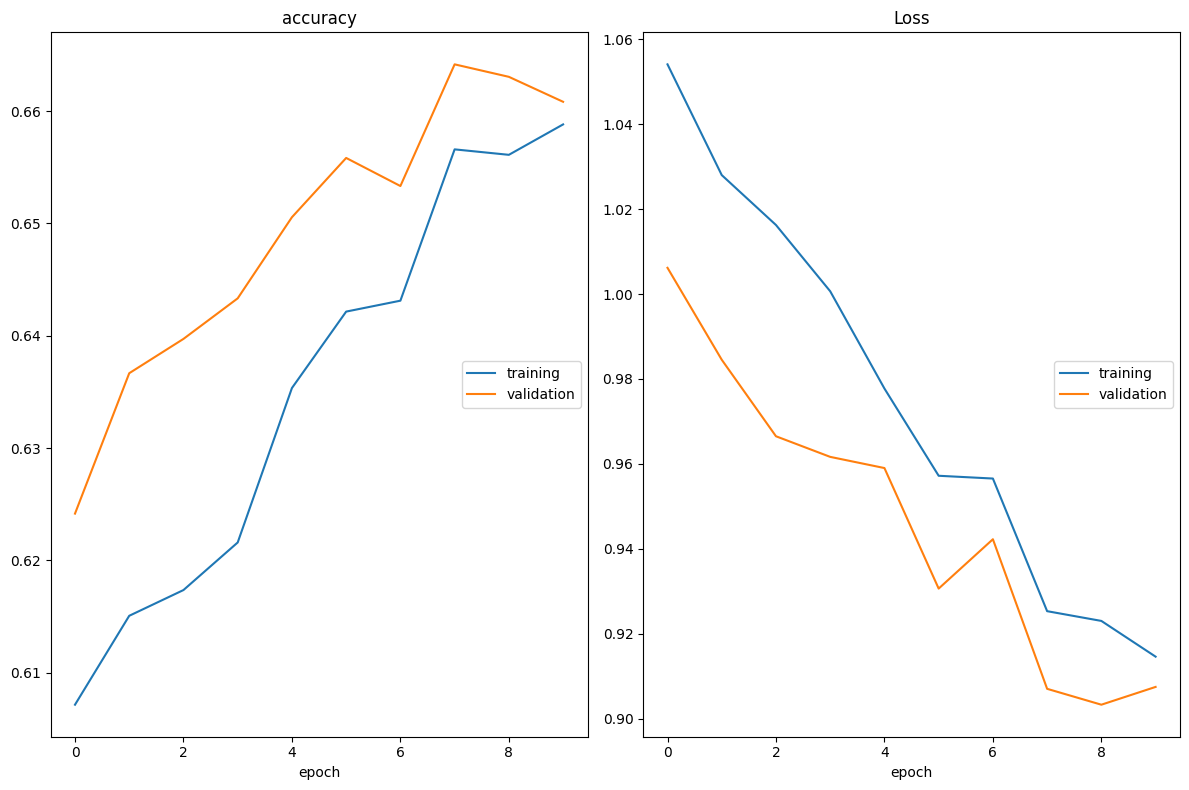

accuracy
	training         	 (min:    0.607, max:    0.659, cur:    0.659)
	validation       	 (min:    0.624, max:    0.664, cur:    0.661)
Loss
	training         	 (min:    0.915, max:    1.054, cur:    0.915)
	validation       	 (min:    0.903, max:    1.006, cur:    0.907)
450/450 [==============================] - 478s 1s/step - loss: 0.9146 - accuracy: 0.6588 - val_loss: 0.9075 - val_accuracy: 0.6608
Training Time:  1:27:39.308727


In [52]:
from livelossplot import PlotLossesKeras
# fit the model
start = datetime.now()
history = model1.fit(x=x_train,
                     y=y_train,
                     epochs=10,
                     validation_split=0.2,
                     batch_size=32,
                     validation_data=(x_validate,y_validate),
                     callbacks=[PlotLossesKeras()]
                     )
stop = datetime.now() - start
print("Training Time: ", stop)

In [53]:
loss, accuracy = model1.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 398s 881ms/step - loss: 0.7422 - accuracy: 0.7307
Train: accuracy = 0.730694  ;  loss = 0.742172


In [54]:
loss, accuracy = model1.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 127s 843ms/step - loss: 1.2875 - accuracy: 0.5218
Testing: accuracy = 0.521778  ;  loss = 1.287528


141/141 [==============================] - 167s 1s/step
Accuracy: 0.5218
Precision: 0.5732
Recall: 0.5275
F1-score: 0.5168
Kappa score: 0.4626


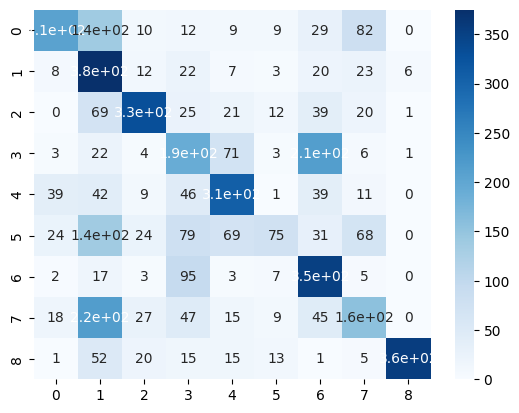

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model1.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

In [57]:
from sklearn.metrics import classification_report

y_pred = model1.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

141/141 [==============================] - 133s 936ms/step
              precision    recall  f1-score   support

           0       0.69      0.42      0.52       497
           1       0.35      0.79      0.49       476
           2       0.75      0.64      0.69       517
           3       0.36      0.37      0.36       515
           4       0.59      0.62      0.61       494
           5       0.57      0.15      0.23       507
           6       0.46      0.73      0.56       484
           7       0.41      0.29      0.34       533
           8       0.98      0.74      0.85       477

    accuracy                           0.52      4500
   macro avg       0.57      0.53      0.52      4500
weighted avg       0.57      0.52      0.51      4500



`Model Architecture VGG16`

In [58]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau

In [59]:
model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model2 = Sequential()
for layer in model_VGG16.layers:
    layer.trainable = False
model2.add(model_VGG16)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dropout_1 (Dropout)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               1573376   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)               

In [60]:
from keras.optimizers import SGD
# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

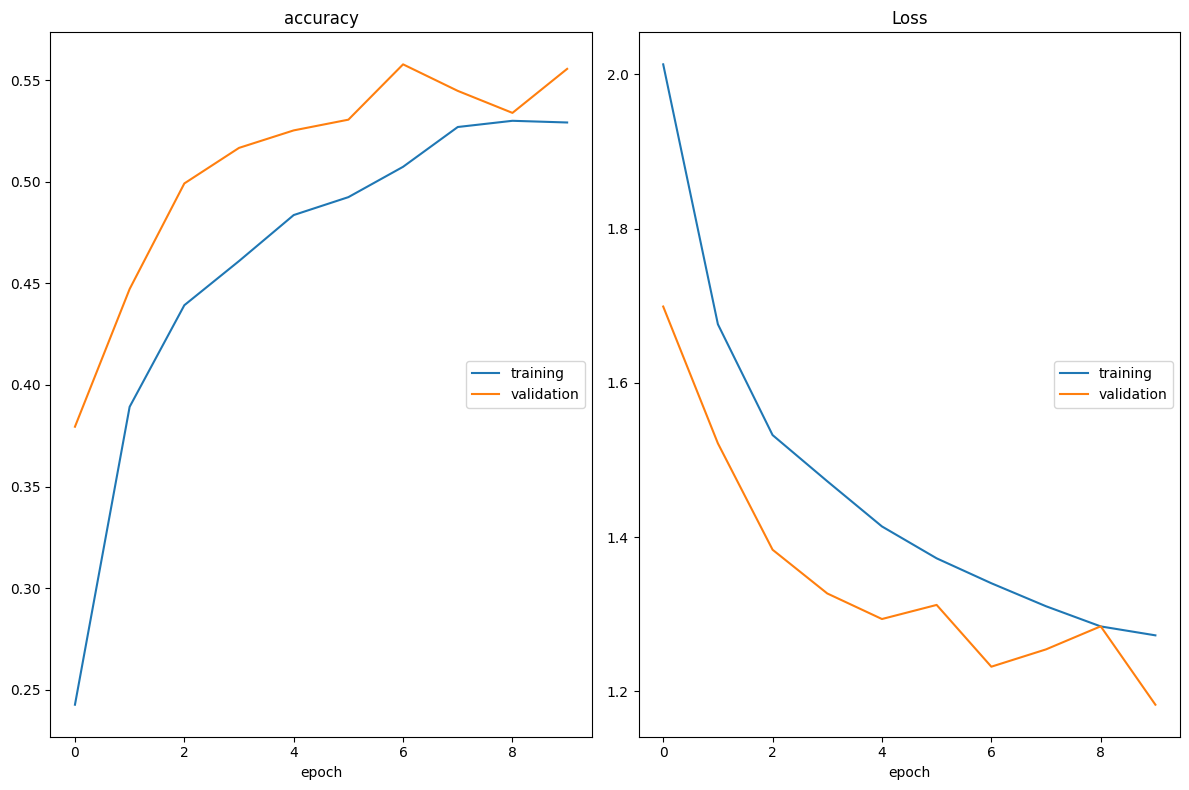

accuracy
	training         	 (min:    0.243, max:    0.530, cur:    0.529)
	validation       	 (min:    0.379, max:    0.558, cur:    0.556)
Loss
	training         	 (min:    1.273, max:    2.013, cur:    1.273)
	validation       	 (min:    1.183, max:    1.699, cur:    1.183)
450/450 [==============================] - 341s 758ms/step - loss: 1.2727 - accuracy: 0.5292 - val_loss: 1.1827 - val_accuracy: 0.5556


In [61]:
# Fit the model
history = model2.fit(x=x_train,
                    y=y_train,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_validate, y_validate),
                    callbacks=[PlotLossesKeras()])

In [62]:
loss, accuracy = model2.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 269s 597ms/step - loss: 1.0813 - accuracy: 0.6003
Train: accuracy = 0.600347  ;  loss = 1.081311


In [63]:
loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 85s 597ms/step - loss: 1.7225 - accuracy: 0.3700
Train: accuracy = 0.370000  ;  loss = 1.722463


141/141 [==============================] - 86s 607ms/step


<Axes: >

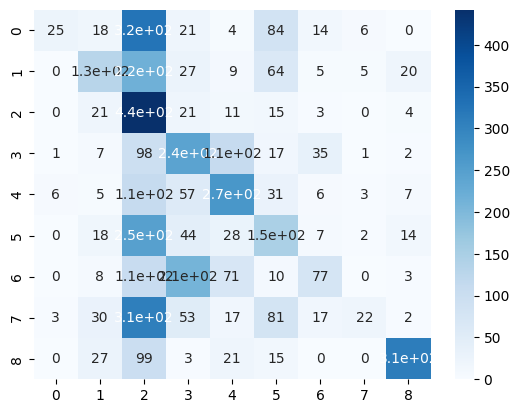

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model2.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.3700
Precision: 0.4994
Recall: 0.3706
F1-score: 0.3430
Kappa score: 0.2902


In [66]:
from sklearn.metrics import classification_report

y_pred = model2.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

141/141 [==============================] - 83s 590ms/step
              precision    recall  f1-score   support

           0       0.71      0.05      0.09       497
           1       0.49      0.27      0.35       476
           2       0.23      0.85      0.36       517
           3       0.36      0.47      0.41       515
           4       0.50      0.54      0.52       494
           5       0.32      0.29      0.30       507
           6       0.47      0.16      0.24       484
           7       0.56      0.04      0.08       533
           8       0.86      0.65      0.74       477

    accuracy                           0.37      4500
   macro avg       0.50      0.37      0.34      4500
weighted avg       0.50      0.37      0.34      4500



`Predicted`

In [67]:
def predict_single(model, x_random, y_random, label_map):
    predictions = model.predict(x_random)
    for i in range(len(x_random)):
        print(f"Actual: {label_map[np.argmax(y_random[i])]}")
        print(f"Predicted: {label_map[np.argmax(predictions[i])]}")
        print()

In [68]:
import random

# test
random_indices = random.sample(range(len(x_test)), 6)
x_random = x_test[random_indices]
y_random = y_test[random_indices]

print("DenseNet201")
predict_single(model1, x_random, y_random, label_map)

DenseNet201
1/1 [==============================] - 2s 2s/step
Actual: vascular lesion
Predicted: vascular lesion

Actual: vascular lesion
Predicted: vascular lesion

Actual: vascular lesion
Predicted: vascular lesion

Actual: basal cell carcinoma
Predicted: basal cell carcinoma

Actual: dermatofibroma
Predicted: dermatofibroma

Actual: dermatofibroma
Predicted: pigmented benign keratosis



In [69]:
random_indices = random.sample(range(len(x_test)), 6)
x_random = x_test[random_indices]
y_random = y_test[random_indices]

print("VGG16")
predict_single(model2, x_random, y_random, label_map)

VGG16
1/1 [==============================] - 0s 217ms/step
Actual: nevus
Predicted: squamous cell carcinoma

Actual: nevus
Predicted: nevus

Actual: vascular lesion
Predicted: vascular lesion

Actual: actinic keratosis
Predicted: dermatofibroma

Actual: nevus
Predicted: nevus

Actual: squamous cell carcinoma
Predicted: dermatofibroma

